In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

def aperture(x,y,N_app, args, type='c'):
    xlin = np.linspace(-x/2, x/2, N_app)
    ylin = np.linspace(-y/2, y/2, N_app)
    X, Y = np.meshgrid(xlin, ylin)
    # circular aperture
    R = np.sqrt(X**2 + Y**2)
    if type=='c':
        r=args[0]
        apert = (R <= r).astype(float)
    if type=='r':
        lx=args[0]
        ly=args[1]
        apert = (np.abs(X) <= lx/2).astype(float) * (np.abs(Y) <= ly/2).astype(float)
    if type=='a':
        r1=args[0]
        r2=args[1]
        apert = ((R >= r1) & (R <= r2)).astype(float)
    if type=='p':
        r=args[0]
        apert = (R >= r).astype(float)

    return apert, xlin, ylin

def screen(x,y,N_scr):
    xlin = np.linspace(-x/2, x/2, N_scr)
    ylin = np.linspace(-y/2, y/2, N_scr)
    X, Y = np.meshgrid(xlin, ylin)
    screen = X, Y
    return screen, xlin, ylin

def pWavefun(x,y,z,wavelength):
    k = 2 * np.pi / wavelength
    planewave = np.cos(k * z)
    return planewave

def integrate_field(xi,yi,zi,xlin,ylin, wavelength, apert):
    k = 2 * np.pi / wavelength
    amplitude = 0
    for i in range(xlin.shape[0]):
        for j in range(ylin.shape[0]):
            xj = xlin[i]
            yj = ylin[j]
            r = np.sqrt((xj - xi)**2 + (yj - yi)**2 + zi**2)
            amplitude +=  1 * np.exp(1j * k * r) / r * pWavefun(xj,yj,0,wavelength) * apert[j,i]
    return amplitude.real

def diffraction(apert, xlin, ylin, screen, sxlin, sylin, wavelength, z):
    for i in range(sxlin.shape[0]):
        for j in range(sylin.shape[0]):
            print(f"\r Rendering... {i*sxlin.shape[0]+j+1}/{sxlin.shape[0]*sylin.shape[0]}", end="")
            xi = sxlin[i]
            yi = sylin[j]
            zi = z
            X, Y = screen  # unpack the meshgrid tuple
            X[i, j] = integrate_field(xi, yi, zi, xlin, ylin, wavelength, apert)
    return screen

def diffraction_optimized(apert, xlin, ylin, sxlin, sylin, wavelength, z, chunk_size=100):
    """并行处理，优化内存使用，避免内存泄漏"""
    k = 2 * np.pi / wavelength

    # 稀疏化：只处理非零孔径点
    X_aper, Y_aper = np.meshgrid(xlin, ylin, indexing='ij')
    apert_mask = apert.T != 0
    x_aper_nz = X_aper[apert_mask]
    y_aper_nz = Y_aper[apert_mask]
    apert_nz = apert.T[apert_mask]

    # 预分配结果数组
    result = np.zeros((len(sxlin), len(sylin)), dtype=np.float32)

    # 分块处理屏幕点
    for i in range(0, len(sxlin), chunk_size):
        for j in range(0, len(sylin), chunk_size):
            i_end = min(i + chunk_size, len(sxlin))
            j_end = min(j + chunk_size, len(sylin))

            # 当前块的屏幕坐标
            sx_chunk = sxlin[i:i_end]
            sy_chunk = sylin[j:j_end]
            X_chunk, Y_chunk = np.meshgrid(sx_chunk, sy_chunk, indexing='ij')

            # 向量化计算
            x_screen_flat = X_chunk.ravel()
            y_screen_flat = Y_chunk.ravel()
            dx = x_screen_flat[:, np.newaxis] - x_aper_nz[np.newaxis, :]
            dy = y_screen_flat[:, np.newaxis] - y_aper_nz[np.newaxis, :]
            r = np.sqrt(dx**2 + dy**2 + z**2)

            # 计算复振幅贡献
            contributions = np.exp(1j * k * r) / r * apert_nz[np.newaxis, :]
            result_chunk = np.sum(contributions, axis=1) / (1j * wavelength)
            result[i:i_end, j:j_end] = np.square(np.abs(result_chunk)).reshape((i_end-i, j_end-j))

            # release memory
            del X_chunk, Y_chunk, x_screen_flat, y_screen_flat, dx, dy, r, contributions, result_chunk

            if (j_end % 10 == 0) and (i_end % 10 == 0):
                # print(f"\r Rendering... {i_end * len(sylin) + j_end}/{len(sxlin) * len(sylin)}", end="")
                print(f"\r Rendering... {i_end}/{len(sxlin)} rows processed", end="")
    return result


# parameters
wavelength = 589.3e-9 # m # wavelength
# screen distance
z = 0.50           # 观察距离

ap_x = 5e-3
ap_y = 5e-3
N_app = 400
sc_x = 5e-3
sc_y = 5e-3
N_scr = 400

aper, xlin, ylin = aperture(ap_x, ap_y, N_app,  [0.25e-3, 0.5e-3], type='a')
# aper, xlin, ylin = aperture(ap_x, ap_y, N_app,  [0.5e-3, 1e-3], type='c')
# aper, xlin, ylin = aperture(ap_x, ap_y, N_app, [0.2e-2, 0.03e-2], type='r')
# aper, xlin, ylin = aperture(ap_x, ap_y, N_app, [1e-3], type='p')

scre, sxlin, sylin = screen(sc_x, sc_y, N_scr)
# deff = diffraction(aper, xlin, ylin, scre, sxlin, sylin, 632.8e-9, 200e-3)
deff = diffraction_optimized(aper, xlin, ylin, sxlin, sylin, wavelength, z, chunk_size=100)
# deff = diffraction(aper, xlin, ylin, scre, sxlin, sylin, wavelength, z)


 Rendering... 400/400 rows processed

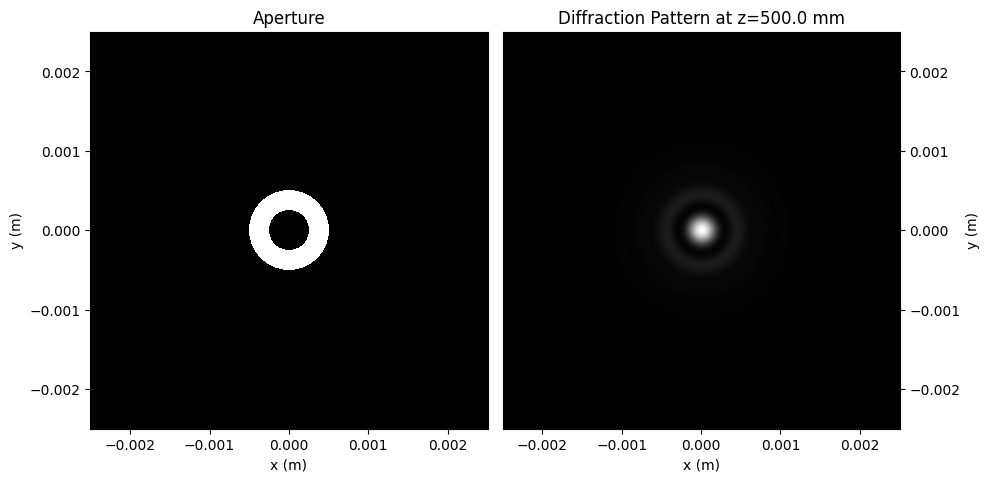

In [5]:
# plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(aper, extent=(-ap_x/2, ap_x/2, -ap_y/2, ap_y/2), cmap='gray', interpolation='nearest')
ax[0].set_title("Aperture")
ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("y (m)")
ax[1].imshow(deff,   interpolation='bilinear', extent=(-sc_x/2, sc_x/2, -sc_y/2, sc_y/2), cmap='gray')
ax[1].set_title(f"Diffraction Pattern at z={z*1e3} mm")
ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("y (m)")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
fig.tight_layout()
fig.savefig("../figure/q3_3_diffraction_pattern.pdf")

圆屏衍射2D分布计算
波长: 589.3 nm
圆屏半径: 2.0 mm
观察距离: 1.0 m
观察区域: 10.0 mm
分辨率: 1000×1000

菲涅尔数: 6.79


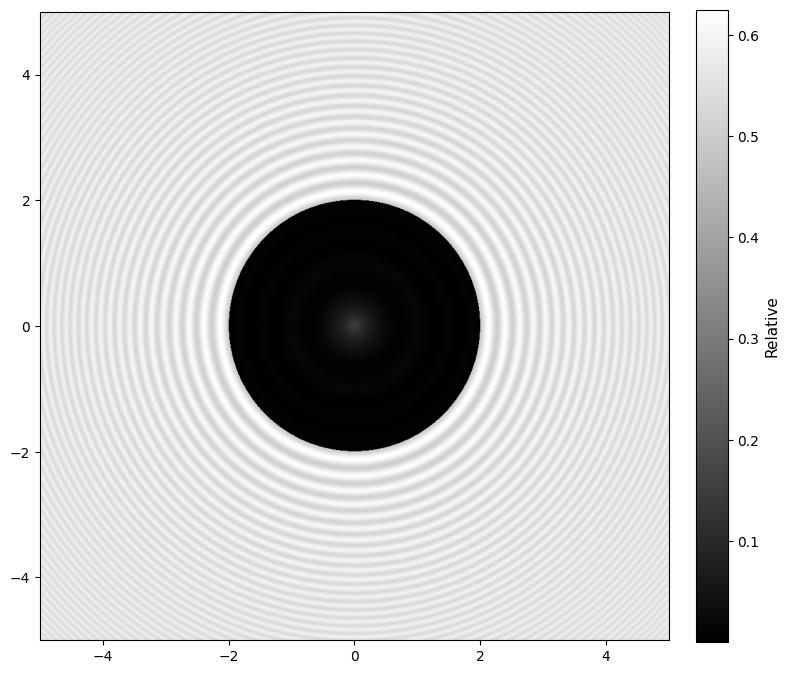

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import fresnel
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap

def circular_diffraction_2d(wavelength, radius, distance, screen_size, resolution):
    """
    计算圆屏菲涅尔衍射的2D强度分布
    
    参数:
    wavelength: 波长 (m)
    radius: 圆屏半径 (m)
    distance: 观察距离 (m)
    screen_size: 观察屏尺寸 (m)
    resolution: 分辨率
    """
    # 创建坐标网格
    x = np.linspace(-screen_size/2, screen_size/2, resolution)
    y = np.linspace(-screen_size/2, screen_size/2, resolution)
    X, Y = np.meshgrid(x, y)
    
    # 计算每点到中心的距离
    R = np.sqrt(X**2 + Y**2)
    
    # 初始化强度矩阵
    intensity = np.zeros_like(R)
    
    # 计算菲涅尔参数
    u_disk = np.sqrt(2 * radius**2 / (wavelength * distance))
    
    # 对每个点计算衍射强度
    for i in range(resolution):
        for j in range(resolution):
            r = R[i, j]
            
            if r == 0:
                # 中心点特殊处理
                C_u, S_u = fresnel(u_disk)
                U = 0.5 * ((C_u) + 1j * (S_u))
                intensity[i, j] = abs(U)**2
            else:
                # 计算该点对应的菲涅尔参数
                u_point = np.sqrt(2 * r**2 / (wavelength * distance))
                
                # 计算菲涅尔积分
                C_u, S_u = fresnel(u_disk)
                C_v, S_v = fresnel(u_point)
                
                if r < radius:
                    # 几何阴影区（圆屏内）
                    U = 0.5 * ((C_u - C_v) + 1j * (S_u - S_v))
                else:
                    # 几何照明区（圆屏外）
                    U = 0.5 * (1 + (C_u - C_v) + 1j * (1 + S_u - S_v))
                
                intensity[i, j] = abs(U)**2
    
    return X, Y, intensity

# 设置参数
wavelength = 589.3e-9  # 钠黄光波长 (m)
radius = 2e-3          # 圆屏半径 (m)
distance = 1.0         # 观察距离 (m)
screen_size = 10e-3    # 观察区域大小 (m)
resolution = 1000       # 分辨率

print("圆屏衍射2D分布计算")
print("=" * 50)
print(f"波长: {wavelength*1e9:.1f} nm")
print(f"圆屏半径: {radius*1e3:.1f} mm")
print(f"观察距离: {distance:.1f} m")
print(f"观察区域: {screen_size*1e3:.1f} mm")
print(f"分辨率: {resolution}×{resolution}")
print()

# 计算2D衍射分布
X, Y, intensity = circular_diffraction_2d(wavelength, radius, distance, screen_size, resolution)

# 计算菲涅尔数
fresnel_number = radius**2 / (wavelength * distance)
print(f"菲涅尔数: {fresnel_number:.2f}")

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(intensity, extent=[-screen_size/2*1e3, screen_size/2*1e3, 
                                 -screen_size/2*1e3, screen_size/2*1e3],
               origin='lower', aspect='equal', cmap='gray')
cbar1 = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar1.set_label('Relative', fontsize=11)
fig.tight_layout()


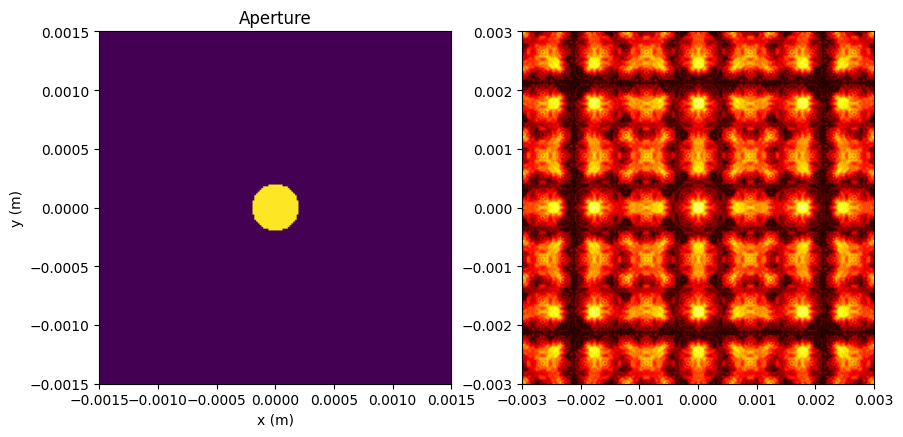

In [20]:
def fresnel_diffraction_fft(aperture_func, wavelength=532e-9, z=0.5, 
                           N1=200, a1=20e-3, b1=20e-3,
                           N=200, a=100e-3, b=100e-3):
    """
    使用傅里叶变换计算菲涅尔衍射
    - aperture_func: 孔径函数，aperture_func(X1, Y1)-> aperture distribution E1
    - wavelength: 波长 (m)
    - z: 观察距离 (m)
    - N1: 孔径平面网格数
    - a1, b1: 孔径平面尺寸 (m)
    - N: 观察平面网格数
    - a, b: 观察平面尺寸 (m)
    """
    
    # 波数
    k = 2 * np.pi / wavelength
    
    # 定义孔径平面
    x1 = np.linspace(-a1/2, a1/2, N1)
    y1 = np.linspace(-b1/2, b1/2, N1)
    dx1dy1 = (a1/N1) * (b1/N1)  # 微元面积
    X1, Y1 = np.meshgrid(x1, y1)
    
    # 定义观察平面
    x = np.linspace(-a/2, a/2, N)
    y = np.linspace(-b/2, b/2, N)
    X, Y = np.meshgrid(x, y)
    
    # 生成孔径分布
    E1 = aperture_func(X1, Y1, a1, b1, N1)
    
    # 菲涅尔衍射的傅里叶变换实现
    # 这是菲涅尔衍射的角谱传播公式
    
    # 频域坐标
    dx = a1 / N1
    fx = np.fft.fftfreq(N1, dx)
    fy = np.fft.fftfreq(N1, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # 菲涅尔传播因子（角谱方法）
    # H = exp(1j * k * z * sqrt(1 - (lambda*fx)^2 - (lambda*fy)^2))
    # 对于小角度近似: H ≈ exp(1j * k * z) * exp(-1j * pi * lambda * z * (fx^2 + fy^2))
    
    # 计算传播因子
    propagation_factor = np.exp(1j * k * z) * np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))
    
    # 对孔径函数进行傅里叶变换
    E1_fft = np.fft.fft2(E1)
    
    # 在频域中应用传播因子
    E_fft = E1_fft * propagation_factor
    
    # 反傅里叶变换得到观察平面的场分布
    E_temp = np.fft.ifft2(E_fft)
    
    # 调整到观察平面的坐标系
    # 这里需要进行坐标变换和插值
    # 简化处理：直接使用中心部分
    center_start = N1//2 - N//2
    center_end = N1//2 + N//2
    
    if center_start >= 0 and center_end <= N1:
        E = E_temp[center_start:center_end, center_start:center_end]
    else:
        # 如果观察区域超出计算区域，进行零填充或截取
        E = np.zeros((N, N), dtype=complex)
        src_start_i = max(0, center_start)
        src_end_i = min(N1, center_end)
        src_start_j = max(0, center_start)
        src_end_j = min(N1, center_end)
        
        dst_start_i = max(0, -center_start)
        dst_end_i = dst_start_i + (src_end_i - src_start_i)
        dst_start_j = max(0, -center_start)
        dst_end_j = dst_start_j + (src_end_j - src_start_j)
        
        E[dst_start_i:dst_end_i, dst_start_j:dst_end_j] = E_temp[src_start_i:src_end_i, src_start_j:src_end_j]
    
    return X1, Y1, E1, X, Y, np.abs(E)

# 定义各种孔径函数
def rectangular_aperture(X1, Y1, a1, b1, N1):
    """矩形孔径"""
    E1 = np.zeros((N1, N1))
    E1[np.abs(X1) < a1/15] = 1
    E1[np.abs(Y1) < b1/15] = 1
    E1[np.abs(X1) > a1/15] = 0
    E1[np.abs(Y1) > b1/15] = 0
    return E1

def circular_aperture(X1, Y1, a1, b1, N1):
    """圆形孔径"""
    E1 = np.zeros((N1, N1))
    E1[np.sqrt(X1**2 + Y1**2) < a1/15] = 1
    return E1

def annular_aperture(X1, Y1, a1, b1, N1):
    """环形孔径"""
    E1 = np.zeros((N1, N1))
    radius_outer = a1/15
    radius_inner = b1/15
    E1[(np.sqrt(X1**2 + Y1**2) < radius_outer) & (np.sqrt(X1**2 + Y1**2) > radius_inner)] = 1
    return E1

def double_circular_aperture(X1, Y1, a1, b1, N1):
    """双圆孔径"""
    E1 = np.zeros((N1, N1))
    E2 = np.zeros((N1, N1))
    radius = a1/32
    E1[np.sqrt((X1 - a1/4)**2 + Y1**2) < radius] = 1
    E2[np.sqrt((X1 + a1/4)**2 + Y1**2) < radius] = 1
    return E1 + E2

def triple_circular_aperture(X1, Y1, a1, b1, N1):
    """三圆孔径"""
    E1 = np.zeros((N1, N1))
    E2 = np.zeros((N1, N1))
    E3 = np.zeros((N1, N1))
    radius = a1/32
    E1[np.sqrt(X1**2 + Y1**2) < radius] = 1
    E2[np.sqrt((X1 - a1/6)**2 + Y1**2) < radius] = 1
    E3[np.sqrt((X1 + a1/6)**2 + Y1**2) < radius] = 1
    return E1 + E2 + E3

def cross_aperture(X1, Y1, a1, b1, N1):
    """十字形孔径"""
    E1 = np.zeros((N1, N1))
    E2 = np.zeros((N1, N1))
    E1[int(N1*40/100):int(N1*60/100), int(N1*49/100):int(N1*51/100)] = 1
    E2[int(N1*49/100):int(N1*51/100), int(N1*40/100):int(N1*60/100)] = 1
    result = E1 + E2
    result[result > 0] = 1
    return result

def diamond_aperture(X1, Y1, a1, b1, N1):
    """菱形孔径"""
    E1 = np.ones((N1, N1))
    radius = a1/12
    coefficient = 2
    E1[Y1 >= radius - coefficient*X1] = 0
    E1[Y1 >= radius + coefficient*X1] = 0
    E1[Y1 <= -radius - coefficient*X1] = 0
    E1[Y1 <= -radius + coefficient*X1] = 0
    return E1

def triangle_aperture(X1, Y1, a1, b1, N1):
    """三角形孔径"""
    E1 = np.ones((N1, N1))
    radius = a1/12
    coefficient = 2
    E1[Y1 <= 0] = 0
    E1[Y1 >= radius - coefficient*X1] = 0
    E1[Y1 >= radius + coefficient*X1] = 0
    return E1

def single_slit_aperture(X1, Y1, a1, b1, N1):
    """单缝孔径"""
    E1 = np.zeros((N1, N1))
    E1[np.abs(Y1) < b1/15] = 1
    return E1

def getApert(aperture_func, N1=200, a1=20e-3, b1=20e-3):
    x1 = np.linspace(-a1/2, a1/2, N1)
    y1 = np.linspace(-b1/2, b1/2, N1)
    X1, Y1 = np.meshgrid(x1, y1)
    E1 = aperture_func(X1, Y1, a1, b1, N1)
    return E1
wavelength = 589.3e-9 # m # wavelength
# screen distance
z = 0.50           # 观察距离

ap_x = 5e-3
ap_y = 5e-3
N_app = 400
sc_x = 5e-3
sc_y = 5e-3
N_scr = 400

aper, xlin, ylin = aperture(ap_x, ap_y, N_app,  [0.5e-3, 1e-3], type='a')
# aper, xlin, ylin = aperture(ap_x, ap_y, N_app, [0.2e-2, 0.03e-2], type='r')
# aper, xlin, ylin = aperture(ap_x, ap_y, N_app, [1e-3], type='p')

scre, sxlin, sylin = screen(sc_x, sc_y, N_scr)

# 与上文相同的参数, 计算
# deff_fft = fresnel_diffraction_fft(circular_aperture, wavelength, z, N1=20,a1=1e-3,b1=0.5e-3,N=200,a=5e-3,b=5e-3)
# deff_fft = fresnel_diffraction_fft(annular_aperture, wavelength, z, N1=1000,a1=3e-3,b1=3e-3,N=1000,a=6e-3,b=6e-3)
# deff_fft = fresnel_diffraction_fft(single_slit_aperture, wavelength, z, N1=200,a1=3e-3,b1=3e-3,N=200,a=6e-3,b=6e-3)
deff_fft = fresnel_diffraction_fft(circular_aperture, wavelength, z, N1=1000,a1=1e-3,b1=1e-3,N=1000,a=6e-3,b=6e-3)
aperture_image = getApert(circular_aperture, N1=200, a1=1e-3, b1=1e-3)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(aperture_image, extent=(-1.5e-3, 1.5e-3, -1.5e-3, 1.5e-3))
ax[0].set_title("Aperture")
ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("y (m)")   
ax[1].imshow(deff_fft[5], extent=(-3e-3, 3e-3, -3e-3, 3e-3), cmap='hot', interpolation='bilinear')

# plt.imshow(deff_fft[5], extent=(-3e-3, 3e-3, -3e-3, 3e-3), cmap='hot', interpolation='bilinear')

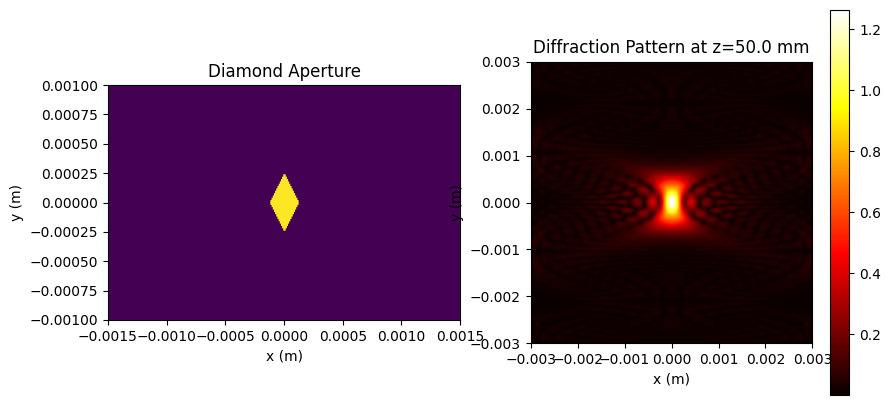

In [154]:
# 使用 diamond_aperture 作为孔径函数，a1=a, b1=b
a = 3e-3  # 对角线长度 a (单位: 米)
b = 2e-3  # 对角线长度 b (单位: 米)
N1 = 300  # 孔径网格数
N = 300   # 观察屏网格数

# 计算菲涅尔衍射场
X1, Y1, E1, X, Y, intensity = fresnel_diffraction_fft(
    diamond_aperture, wavelength=wavelength, z=z,
    N1=N1, a1=a, b1=b, N=N, a=2*a, b=2*a
)

# 可视化
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(E1, extent=(-a/2, a/2, -b/2, b/2))
ax[0].set_title("Diamond Aperture")
ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("y (m)")
im = ax[1].imshow(intensity, extent=(-a, a, -a, a), cmap='hot', interpolation='bilinear')
ax[1].set_title(f"Diffraction Pattern at z={z*1e3} mm")
ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("y (m)")
plt.colorbar(im, ax=ax[1])


 Computing... 200/200

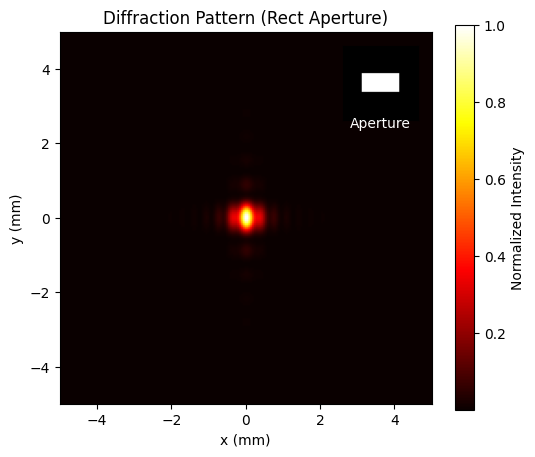

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
wavelength = 633e-9  # 波长 (m)
k = 2 * np.pi / wavelength
z = 0.5  # 孔径到屏幕距离 (m)

# 屏幕坐标
screen_size = 0.01  # 屏幕尺寸 (m)
num_points = 200
x = np.linspace(-screen_size/2, screen_size/2, num_points)
y = np.linspace(-screen_size/2, screen_size/2, num_points)
X, Y = np.meshgrid(x, y)

# 孔径坐标
aperture_size = 0.002  # 孔径区域 (m)
num_aperture = 200
x0 = np.linspace(-aperture_size/2, aperture_size/2, num_aperture)
y0 = np.linspace(-aperture_size/2, aperture_size/2, num_aperture)
X0, Y0 = np.meshgrid(x0, y0)
dA = (aperture_size/num_aperture)**2

# 孔径类型定义
def aperture_circle(X0, Y0, radius=0.0005):
    return (X0**2 + Y0**2 <= radius**2).astype(float)

def aperture_rect(X0, Y0, width=0.001, height=0.0005):
    return ((np.abs(X0) <= width/2) & (np.abs(Y0) <= height/2)).astype(float)

def aperture_double_slit(X0, Y0, slit_width=0.0002, slit_height=0.0015, slit_distance=0.0006):
    slit1 = ((np.abs(X0-slit_distance/2) <= slit_width/2) & (np.abs(Y0) <= slit_height/2))
    slit2 = ((np.abs(X0+slit_distance/2) <= slit_width/2) & (np.abs(Y0) <= slit_height/2))
    return (slit1 | slit2).astype(float)

# 选择孔径类型
aperture_type = 'rect'  # 'circle', 'rect', 'double_slit'

if aperture_type == 'circle':
    aperture = aperture_circle(X0, Y0, radius=0.0005)
elif aperture_type == 'rect':
    aperture = aperture_rect(X0, Y0, width=0.001, height=0.0005)
elif aperture_type == 'double_slit':
    aperture = aperture_double_slit(X0, Y0, slit_width=0.0001, slit_height=0.115, slit_distance=0.0006)

# 菲涅尔积分计算
U = np.zeros_like(X, dtype=complex)

for i in range(num_points):
    for j in range(num_points):
        phase = np.exp(1j * k / (2 * z) * ((X[i, j] - X0)**2 + (Y[i, j] - Y0)**2))
        U[i, j] = np.sum(aperture * phase) * dA / z
    print(f"\r Computing... {i+1}/{num_points}", end="")

# 归一化强度
I = np.abs(U)**2
I /= I.max()

# 绘图
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(I, extent=[x.min()*1e3, x.max()*1e3, y.min()*1e3, y.max()*1e3], cmap='hot')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_title(f'Diffraction Pattern ({aperture_type.capitalize()} Aperture)')
plt.colorbar(im, ax=ax, label='Normalized Intensity')

# 添加右上角孔径小图
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="20%", height="20%", loc='upper right', borderpad=1)
axins.imshow(aperture, extent=[x0.min()*1e3, x0.max()*1e3, y0.min()*1e3, y0.max()*1e3], cmap='gray')
axins.set_axis_on()
axins.text(0.5, -0.1, 'Aperture', transform=axins.transAxes, ha='center', fontsize=10, color='white')
# axins.set_title('Aperture', fontsize=10)
axins.set_xticks([])
axins.set_yticks([])

plt.show()
